In [4]:
import requests
from dotenv import load_dotenv
from urllib.parse import urlparse
from urllib.parse import parse_qs
from os import getenv
from requests.models import PreparedRequest
from requests import get

load_dotenv()

True

In [5]:
def add_key(params):
    return {"key": getenv('API_KEY'), **params}

In [6]:
u = 'https://www.youtube.com/watch?v=9yDDnurRmIY'


def get_video_key(p_url):
    parsed_url = urlparse(p_url)
    captured_value = parse_qs(parsed_url.query)['v'][0]
    return captured_value

get_video_key(u)

'9yDDnurRmIY'

# Things we need from youtube

1. Search Results - we have a prompt and we need to search youtube videos which are relevant to the prompt
2. Transcripts for the Video - Either Auto Translated/Generated English Transcripts or the Already Present Transcripts (EN) for the video


# Understanding the Results of the Video

Every video has a Key: `video_key`
and below are the details of the video we can fetch from the API.

we call the [GetVideos](https://developers.google.com/youtube/v3/docs/videos/list?apix_params=%7B%22part%22%3A%5B%22snippet%2CcontentDetails%2Cstatistics%22%5D%2C%22id%22%3A%5B%229yDDnurRmIY%22%5D%7D#usage) API which can give the information for single or multiple videos, here we are focusing on the single video.

| Part                        | What is it for                             |
|-----------------------------|--------------------------------------------|
| contentDetails              | Has the Duration of the Video              |
| localizations               | Has the Title and Description of the Video |
| paidProductPlacementDetails | if the Video has any Product ADs related   |
| player                      | URL for embedding the video (IFRAME URL)   |
| snippet                     | has tags and more info. on the Video       |
| statistics                  | views, likes, ... (stats on the video)     |
| topicDetails                | Topic Classification Ig                    |

In [7]:
def search_results(q):
    url = 'https://www.googleapis.com/youtube/v3/search'
    params = add_key({
      'q': q,
      'part': 'snippet',
        'maxResults': 5
    })
    req = PreparedRequest()
    req.prepare_url(url, params)
    return get(req.url)

search_results("how to make a chocolate cake, can you help with me it").json()

{'kind': 'youtube#searchListResponse',
 'etag': 'vk0KnTCMW95BdMGWmtoMSPPz6us',
 'nextPageToken': 'CAUQAA',
 'regionCode': 'DK',
 'pageInfo': {'totalResults': 1000000, 'resultsPerPage': 5},
 'items': [{'kind': 'youtube#searchResult',
   'etag': 'e_jA1IFiwxzGxeExpA2ln6gvdAU',
   'id': {'kind': 'youtube#video', 'videoId': 'rL4sDLdfn7A'},
   'snippet': {'publishedAt': '2022-03-11T00:54:54Z',
    'channelId': 'UC_35hRJlT4PEmvFCcU6l_3Q',
    'title': 'Chocolate Cake made in a PAN! (No oven)',
    'description': 'shorts #chocolatecake #easyrecipe #onepan #simplerecipe #cake #baking.',
    'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/rL4sDLdfn7A/default.jpg',
      'width': 120,
      'height': 90},
     'medium': {'url': 'https://i.ytimg.com/vi/rL4sDLdfn7A/mqdefault.jpg',
      'width': 320,
      'height': 180},
     'high': {'url': 'https://i.ytimg.com/vi/rL4sDLdfn7A/hqdefault.jpg',
      'width': 480,
      'height': 360}},
    'channelTitle': 'Patrick Zeinali',
    'liveBroad

In [8]:
search_results("how to make a chocolate cake ?").json()

{'kind': 'youtube#searchListResponse',
 'etag': '-uxxQ4UYpgODXR2JcqTQdbzQOVw',
 'nextPageToken': 'CAUQAA',
 'regionCode': 'DK',
 'pageInfo': {'totalResults': 1000000, 'resultsPerPage': 5},
 'items': [{'kind': 'youtube#searchResult',
   'etag': '0eFeD2PGqGwy6QRpZ4GB7OqCT0k',
   'id': {'kind': 'youtube#video', 'videoId': 'EaljSnLrJW8'},
   'snippet': {'publishedAt': '2024-11-30T19:22:31Z',
    'channelId': 'UCVbA86KX-xaa2v9mSIfPcuQ',
    'title': 'Moist &amp; Fudgy Chocolate Cake with Everyday Ingredients',
    'description': 'Kitchen Tools I Cook With: https://amzn.to/47KTh6J * Some links are affiliate links, which means I may earn a small commission at ...',
    'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/EaljSnLrJW8/default.jpg',
      'width': 120,
      'height': 90},
     'medium': {'url': 'https://i.ytimg.com/vi/EaljSnLrJW8/mqdefault.jpg',
      'width': 320,
      'height': 180},
     'high': {'url': 'https://i.ytimg.com/vi/EaljSnLrJW8/hqdefault.jpg',
      'width':

# Challenges we are Facing till now

1. We cannot fetch the Video Details of the Search Prompt as much as we want due to the Quota Limits: https://developers.google.com/youtube/v3/getting-started#quota, Which is a blocker for our Data Generation

# Alternative way to fetch the Search Results

below is another way to fetch the results of the youtube search, it is slower than the actual api but atleast has no limits. Refer this repo for more info: https://scrapetube.readthedocs.io/en/latest/

we use scrapetube which as it name says scraps the data from the websites

In [10]:
import scrapetube

videos = scrapetube.get_search("how to fix a leaky faucet")

In [11]:
for _ in videos:
    print(_["videoId"])
    break

SYPFon69vKs


# Fetching the Youtube Transcripts

Since the Official Youtube data API does not allow the users who do not own the video to download the captions, we can from [youtube-transcript-api](https://github.com/jdepoix/youtube-transcript-api)

`uv add youtube-transcript-api`

In [52]:
from youtube_transcript_api import YouTubeTranscriptApi

ytt_api = YouTubeTranscriptApi()

fetch = ytt_api.fetch(get_video_key('https://www.youtube.com/watch?v=9yDDnurRmIY'))
fetch2 = ytt_api.fetch(get_video_key('https://www.youtube.com/watch?v=y_q741QO_m0'))
fetches = [fetch.to_raw_data(), fetch2.to_raw_data()]
print(fetch)

FetchedTranscript(snippets=[FetchedTranscriptSnippet(text='oh you got to be kidding me zero Ubers', start=0.96, duration=5.52), FetchedTranscriptSnippet(text="we're in the middle of downtown", start=3.659, duration=5.341), FetchedTranscriptSnippet(text='hey get in who the hell are you a really', start=6.48, duration=4.079), FetchedTranscriptSnippet(text="bad start to your day that's who were", start=9.0, duration=3.059), FetchedTranscriptSnippet(text='you just waiting for me out here all day', start=10.559, duration=3.54), FetchedTranscriptSnippet(text='yes sir well do you have like an app to', start=12.059, duration=3.301), FetchedTranscriptSnippet(text="make sure it's safe yeah it's called", start=14.099, duration=3.241), FetchedTranscriptSnippet(text='take my word for it and get the hell in', start=15.36, duration=4.86), FetchedTranscriptSnippet(text='ah you can help me with my bags no we', start=17.34, duration=4.199), FetchedTranscriptSnippet(text="don't work for five star ratings

In [53]:
print(
    fetch.video_id,
    fetch.language,
    fetch.language_code,
    # whether it has been manually created or generated by YouTube
    fetch.is_generated, sep="\n"
)

9yDDnurRmIY
English (auto-generated)
en
True


In [103]:
fetch2.to_raw_data()[:5]

[{'text': "In September 2025, Trump hosted a dinner\nfor Big Tech's top CEOs.",
  'start': 0.0,
  'duration': 4.629},
 {'text': 'The most brilliant people\nare gathered around this table.',
  'start': 4.629,
  'duration': 2.711},
 {'text': '[Trevor]\nMeta, Google, Microsoft, OpenAI.',
  'start': 7.34,
  'duration': 3.462},
 {'text': 'Everyone was there.', 'start': 10.802, 'duration': 1.084},
 {'text': '[Trump]\nThis is definitely a high IQ group.',
  'start': 12.303,
  'duration': 2.044}]

In [ ]:
def raw_data_to_single_text(raw_data):
    texts = "".join(f"{i['text'].replace("\n", " ")} \n" for i in raw_data)
    return "POST: " + texts


In [126]:

def create_list_from_fetches(fetches_list: list):
    return list(map(raw_data_to_single_text, fetches_list))

def format_df(df):
    df["text"] = create_list_from_fetches(df["text"])
    df["text"] = "TITLE: " + df["title"] + "\n\n" + df["text"]
    return df

df = pd.DataFrame({"text":  fetches, "title": ["Uber", "Politics"]})
df = format_df(df)
print(df["text"])
print("\n" + df["text"][1])

0    TITLE: Uber\n\nPOST: oh you got to be kidding ...
1    TITLE: Politics\n\nPOST: In September 2025, Tr...
Name: text, dtype: object

TITLE: Politics

POST: In September 2025, Trump hosted a dinner for Big Tech's top CEOs. 
The most brilliant people are gathered around this table. 
[Trevor] Meta, Google, Microsoft, OpenAI. 
Everyone was there. 
[Trump] This is definitely a high IQ group. 
[Trevor] It was the usual scene: a bunch of people 
around a table praising Trump, thanking him for everything that he's doing. 
[Mark Zuckerberg] Well, thanks for hosting us. 
[Jared Isaacman] Thank you so much. 
[Bill Gates] Thank you. 
[Tim Cook] Thank you for including me. 
[Sam Altman] Thank you for being such a pro-business, 
pro-innovation president. 
[Greg Brockman] Thank you for that. 
[Safra Catz] Thank you. 
But I've got to admit, this dinner in particular, it had me scratching my head. 
It was weird. 
And not just because Zuckerberg got caught on a hot mic trying to be the teacher's pet

In [135]:
f = open('../data/queries.txt', 'r')
content = f.read()

print(len(content.split(",")))

1127


# Challenges till now

we are able to resolve the youtube search but there's neww problem that's this below error:

```
IpBlocked: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=9yDDnurRmIY! This is most likely caused by:

YouTube is blocking requests from your IP. This usually is due to one of the following reasons:
- You have done too many requests and your IP has been blocked by YouTube
- You are doing requests from an IP belonging to a cloud provider (like AWS, Google Cloud Platform, Azure, etc.). Unfortunately, most IPs from cloud providers are blocked by YouTube.

Ways to work around this are explained in the "Working around IP bans" section of the README (https://github.com/jdepoix/youtube-transcript-api?tab=readme-ov-file#working-around-ip-bans-requestblocked-or-ipblocked-exception).


If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!
```

while fetching transcripts, which is a blocker not only for the data generation but for inference. 


so working on Workaround.

# Alternate Solution

there's another library: https://github.com/yt-dlp/yt-dlp it helps us downloading the subtitles file or video itself. we would be now seeing how we can fetch

In [58]:
from yt_dlp import YoutubeDL

ydl_opts = {
    "skip_download": True,
    "writesubtitles": True,
     "subtitleslangs": ['en'],
    # Looks like formats available are vtt, ttml, srv3, srv2, srv1, json3
    "subtitlesformat": "json3",
    "sleep_interval_subtitles": 1,
}
try:
    with YoutubeDL(ydl_opts) as ydl:
        ydl.download(["Os5Lbx0IZtY"])
except Exception as error:
    print(error)

[youtube] Extracting URL: Os5Lbx0IZtY
[youtube] Os5Lbx0IZtY: Downloading webpage


[youtube] Os5Lbx0IZtY: Downloading android sdkless player API JSON
[youtube] Os5Lbx0IZtY: Downloading web safari player API JSON


[youtube] Os5Lbx0IZtY: Downloading m3u8 information


[info] Os5Lbx0IZtY: Downloading 1 format(s): 399+251
[info] There are no subtitles for the requested languages


## Workaround

According to the: https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies we need the cookies 

so do the following make sure to download the extension, 

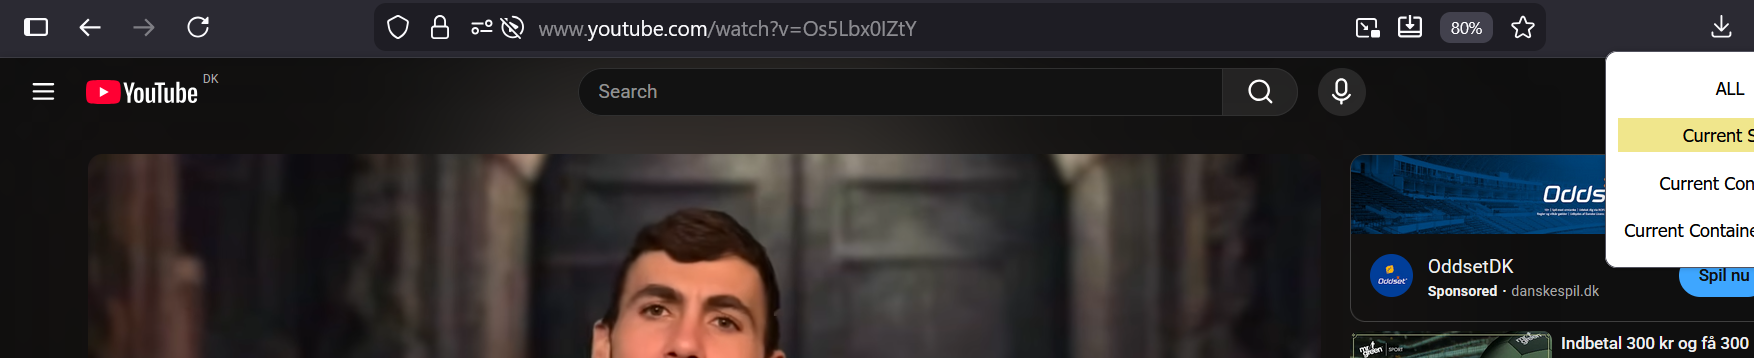

once downloaded we have the cookies.txt file

In [57]:
from yt_dlp import YoutubeDL
from tempfile import TemporaryDirectory
from pathlib import Path
import json

ydl_opts = {
    "skip_download": True,
    "writesubtitles": True,
     "subtitleslangs": ["en", "en-GB", "en-US"],
    "writeautomaticsub": True,
    "cookiefile": 'cookies.txt',
    # Looks like formats available are vtt, ttml, srv3, srv2, srv1, json3
    "subtitlesformat": "json3",
    "sleep_interval_subtitles": 1,
}
try:
    with TemporaryDirectory() as temp_dir:
        temp_path = Path(temp_dir)
        ydl_opts["outtmpl"] = str(temp_path / "%(id)s.%(ext)s")
        with YoutubeDL(ydl_opts) as ydl:
            ydl.download(["Os5Lbx0IZtY"])
        json_files = list(temp_path.glob("*.json3"))
        if not json_files:
            raise ValueError("No subtitles downloaded")
    
        # Load JSON3 and extract plain text
        with open(json_files[0], "r", encoding="utf-8") as f:
            data = json.load(f)
    
        text = " ".join(
            seg['utf8'].replace(r"\n", " ")
            for event in data.get('events', [])
            for seg in event.get('segs', [])
            if 'utf8' in seg
        )
except Exception as error:
    print(error)

[youtube] Extracting URL: Os5Lbx0IZtY
[youtube] Os5Lbx0IZtY: Downloading webpage
[youtube] Os5Lbx0IZtY: Downloading tv downgraded player API JSON
[youtube] Os5Lbx0IZtY: Downloading web safari player API JSON


[youtube] Os5Lbx0IZtY: Downloading m3u8 information
[info] Os5Lbx0IZtY: Downloading subtitles: en
[info] Os5Lbx0IZtY: Downloading 1 format(s): 96
[info] Writing video subtitles to: C:\Users\saiha\AppData\Local\Temp\tmpmzhqa4mg\Os5Lbx0IZtY.en.json3
[download] Sleeping 1.00 seconds ...


[download] Destination: C:\Users\saiha\AppData\Local\Temp\tmpmzhqa4mg\Os5Lbx0IZtY.en.json3
[download] 100% of  131.50KiB in 00:00:00 at 188.42KiB/s


In [78]:
data["events"][:2]

[{'tStartMs': 0,
  'dDurationMs': 316039,
  'id': 1,
  'wpWinPosId': 1,
  'wsWinStyleId': 1},
 {'tStartMs': 120,
  'dDurationMs': 4920,
  'wWinId': 1,
  'segs': [{'utf8': 'so', 'acAsrConf': 0},
   {'utf8': ' you', 'tOffsetMs': 599, 'acAsrConf': 0},
   {'utf8': ' finally', 'tOffsetMs': 799, 'acAsrConf': 0},
   {'utf8': ' found', 'tOffsetMs': 1120, 'acAsrConf': 0},
   {'utf8': ' us', 'tOffsetMs': 1720, 'acAsrConf': 0},
   {'utf8': " I'm", 'tOffsetMs': 2720, 'acAsrConf': 0},
   {'utf8': ' impressed', 'tOffsetMs': 2920, 'acAsrConf': 0},
   {'utf8': ' I', 'tOffsetMs': 3640, 'acAsrConf': 0}]}]

In [79]:
transcript[:2]

[{'text': "so you finally found us I'm impressed I",
  'start': 0.12,
  'duration': 4.92},
 {'text': 'mean you called us on your personal',
  'start': 3.84,
  'duration': 2.8}]